# Bibliotecas e Funções

In [1]:
# Usado para ler arquivos, carregar código personalizado e ter acesso a outros recursos de sistema
import os
import sys
import time
import shutil
from pathlib import Path

# Verificação de tipos
from typing import List, Tuple, Set, Any

# Programação funcional e utilitários
import funcy as fp
import itertools
from functools import partial

# Recursos para texto
import re

# Manipulação e análise dos dados
import numpy as np
import pandas as pd

# Experimentação
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# Algoritmos adicionais para a criação de modelos
from catboost import CatBoostClassifier

# Rastreamento de experimentos e modelos
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.models.signature import infer_signature

# Recursos para visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML, display

# Carregar, além de atualizar frequentemente, código personalizado disponível em ../src
%load_ext autoreload 
%autoreload 2


sys.path.append(str(Path.cwd().parent))
from src import settings
from src.utils.notebooks import display_side_by_side
from src.utils.text import extract_artisanal_text_features
from src.utils.experiments import (compute_entropy,
                                   compute_binary_classification_metrics,
                                   format_nested_parameters)
from src.pipeline.training_pipeline import (compute_embeddings_frame,
                                            create_feature_matrix)
from src.pipeline.wrappers import SupervisedIntentClassificationPreprocessingWrapper

# Configurações para a exibição de conteúdo do Pandas e das bibliotecas gráficas
%matplotlib inline 
sns.set(rc={'figure.figsize':(25,10)})
pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', 150)

# Classificação Supervisionada de Intenções de Busca

A partir da análise preliminar de características extraídas das buscas, realizada no notebook [Análise para Classificação de Intenções](04.2_Analise_para_Classificacao_de_Intencoes.ipynb), parte-se para a criação de um modelo de classificação para determinar a intenção de uma busca. Como itenções de busca estão sendo considerados o **foco**, que permite encontrar os melhores produtos dentro de um segmento mais claro, ou a **exploração**, com o acesso a uma diversidade maior de produtos de diferentes segmentos.

## Configurações de Rastreamento de Experimentos

In [2]:
EXPERIMENT_NAME = '04_SupervisedQueryIntentClassification'
EXPERIMENT_RUN_NAME = f'Structuring'

mlflow_client = MlflowClient()

# If the experiment already exists, retrieve its ID from Mlflow
experiment = mlflow_client.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    mlflow_client.create_experiment(EXPERIMENT_NAME)
    experiment = mlflow_client.get_experiment_by_name(EXPERIMENT_NAME)

EXPERIMENT_ID = experiment.experiment_id
del experiment

## Hiperparâmetros e Funções

Os hiperparâmetros e funções utilizadas são definidos a seguir.

In [3]:
# Data Source params
UNSUPERVISED_INTENT_RUN_ID = settings.USUPERVISED_INTENT_CLASSIFICATION_RUN_ID

# Preprocessing params
EMBEDDING_COLUMNS = ['query']
ARTISANAL_COLUMNS = ['query']

# Training params
STRATIFIED_SPLITS = 10

pipeline_parameters = {'embedding_columns': EMBEDDING_COLUMNS,
                       'artisanal_columns': ARTISANAL_COLUMNS}

## Carregamento do Conjunto de Dados

O conjunto de dados criado para o problema de classificação supervisionada de intenção de busca é carregado com todas as colunas existentes.

In [4]:
columns_to_read = ['query', 'intent_class', 'intent_description']

frame = pd.read_csv(Path(settings.DATA_PATH).joinpath('interim', 'query_intent_training.csv'), usecols=columns_to_read)

display_side_by_side([frame.head(10)], ['Conjunto de Dados de Intenções de Busca'])

,query,intent_class,intent_description
0,lembrancinha 1 ano,0,Busca Exploratória
1,pioneiros,0,Busca Exploratória
2,fibra siliconada,0,Busca Exploratória
3,vestido 15 anos,0,Busca Exploratória
4,quadros personalizados com fotos,1,Busca Focada
5,festa de 50 anos,1,Busca Focada
6,brindes de final de ano,0,Busca Exploratória
7,porta cartao de vacina,0,Busca Exploratória
8,letras de nomes personalizados,1,Busca Focada
9,futon,0,Busca Exploratória


## Preparação de Dados
A seguir, cria-se um *wrapper* com as referências necessárias para pré-processar os dados para a classificação.

In [5]:
preprocessing_wrapper = SupervisedIntentClassificationPreprocessingWrapper(artisanal_features=['query'], embeddings_features=['query'])

Com o *wrapper*, pode-se fazer o pré-processamento dos dados para treinar o modelo de classificação.

In [6]:
X_base = preprocessing_wrapper.predict(_, frame)
y_base = frame['intent_class']

## Balanceamento de Classes

Como há um desbalanceamento no número de registros de cada intenção, é interessante fazer um contra-balanceamento dos pesos para que exista uma proporcionalidade entre eles para o modelo. Assim, a intenção com mais itens deve ter peso menor, enquanto os itens da intenção menos representada deve ter peso maior.

In [7]:
n_samples = len(frame)
n_classes = len(frame['intent_class'].unique())

value_counts_frame = (frame
                      [['intent_class']]
                      .assign(records=1)
                      .groupby(['intent_class'])
                      .sum()
                      .reset_index()                      
                      .assign(weight=lambda f: f['records'].apply(lambda r: n_samples / (n_classes * r)))
                      .assign(label=lambda f: f['intent_class'])
                     )
display_side_by_side([value_counts_frame], ['Distribuição de Classes e Pesos'])

class_weights = {item.label: item.weight for item in value_counts_frame[['label', 'weight']].itertuples(index=False)}

del n_samples, value_counts_frame, frame

,intent_class,records,weight,label
0,0,3463,0.647704,0
1,1,1023,2.192571,1


A seguir, tem-se a estrutura de exploração de algoritmos e parâmetros que podem ser utilizados para criar modelos de classificação. Com o uso do MLFlow, cada experimento pode ser registrado para que o histórico sirva para avaliar as mudanças que foram mais eficazes.

Para fazer a experimentação, consideraria algumas opções:
 - **Catboost**: uma alternativa entre as versões de gradient boosting --  como XBoost e LightGBM -- a partir de árvores de decisão. Oferece recursos para tratamento de variáveis categóricas e textuais, tem bom ajuste automático de hiperparâmetros (considerando os dados) e desempenho, com suporte a GPU, além de suportar dados não preenchidos.
 - **Redes Neurais**: apesar de exigir tratamentos adicionais nos dados (normalização e imputação de valores ausentes), tende a oferecer bom desempenho no cenário atual, especialmente com o uso de *embeddings*.
 - **Random Forest**: um modelo de bagging, também baseado em árvores de decisão.

In [8]:
models_parameters = {    
    'MLP': {'activation':'tanh', 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes':(200, 200)},
    'CB': {'loss_function': 'Logloss', 'iterations': 500, 'save_snapshot': False, 'verbose': False, 'class_weights': class_weights},
    'RF': {'n_estimators':500, 'criterion':'entropy', 'n_jobs':-1, 'class_weight': class_weights},
}

fit_parameters = {    
    'MLP': {},
    'CB': {},
    'RF': {}
}

models_to_train = {
    'MLP': MLPClassifier,
    'CB': CatBoostClassifier,
    'RF': RandomForestClassifier,
}

iterations_tracking = []
trained_models = []
validation_scores = []

with mlflow.start_run(run_name=EXPERIMENT_RUN_NAME, experiment_id=EXPERIMENT_ID) as main_run:
    # A cada execução limpa o diretório de artefatos para gravar novos, a serem salvos no MLflow
    if os.path.exists(settings.LOGS_ARTIFACTS_PATH):
        shutil.rmtree(settings.LOGS_ARTIFACTS_PATH)
    os.makedirs(settings.LOGS_ARTIFACTS_PATH) 

    mlflow.log_param('stratified_splits', STRATIFIED_SPLITS)
    mlflow.log_param('unsupervised_intent_run_id', UNSUPERVISED_INTENT_RUN_ID)

    simple_pipeline_params, complex_pipeline_params = format_nested_parameters(pipeline_parameters, 'pipeline')
    mlflow.log_params(simple_pipeline_params)

    stratified_splitter = StratifiedKFold(n_splits=STRATIFIED_SPLITS, shuffle=True, random_state=392)

    for ix, (train_index, validation_index) in enumerate(stratified_splitter.split(X_base, y_base)):
        # Materializa os datasets do da divisão estratificada
        X_training = X_base[train_index]
        y_training = y_base[train_index]

        X_validation = X_base[validation_index]
        y_validation = y_base[validation_index]

        for model_name, model_class in models_to_train.items():
            
            # Registra a execução aninhada do algoritmo
            with mlflow.start_run(run_name=f'01_{ix}_{EXPERIMENT_RUN_NAME}_{model_name}', experiment_id=EXPERIMENT_ID, nested=True) as nested_run:
                start_time = time.time()
                model = model_class(**models_parameters.get(model_name, {}))
                model.fit(X_training, y_training)
                mlflow.log_metric('training_time', time.time() - start_time)

                trained_models.append((model_name, ix, model)) 
                preds = model.predict(X_validation)

                eval_metrics = compute_binary_classification_metrics(y_validation, preds.round())

                iteration_tracking = {**{'Algorithm': model_name,
                                         'Iteration': ix}, 
                                      **eval_metrics}
                iterations_tracking.append(iteration_tracking)

                validation_scores.append((model_name, ix, eval_metrics['f1']))

                mlflow.log_param('model_name', model_name)
                mlflow.log_params(models_parameters.get(model_name, {}))
                mlflow.sklearn.log_model(model, "model")
                for key, value in eval_metrics.items():
                    mlflow.log_metric(key, np.mean(value))

                # Salva o modelo criado
                signature = infer_signature(X_training, preds)
                mlflow.sklearn.log_model(model, model_name, signature=signature)
                
    # Registra as dimensões dos vetores de treinamento e validação
    mlflow.log_param('X_training', X_training.shape)
    mlflow.log_param('X_validation', X_validation.shape)

    # Métricas de avaliação individual
    evaluation_frame = pd.DataFrame(iterations_tracking)
    evaluation_frame.to_csv(os.path.join(settings.LOGS_ARTIFACTS_PATH, 'experiment_runs.csv'))
    evaluation_frame.to_html(os.path.join(settings.LOGS_ARTIFACTS_PATH, 'experiment_runs.html'))

    # Sumarização das métricas de várias execuções de um mesmo algoritmo    
    evaluation_summary_frame = (evaluation_frame
                                [['Algorithm', 'acc', 'auc', 'mc', 'precision', 'recall', 'f1', 'filtering']]
                                .groupby('Algorithm')
                                .agg([np.mean, np.std])
                               )

    for item in evaluation_summary_frame.itertuples():
        mlflow.log_metric(item.Index, item._7)

    best_result_index = evaluation_summary_frame[('f1', 'mean')].argmax()
    for metric in ['acc', 'auc', 'mc', 'precision', 'recall', 'f1', 'filtering']:
        mlflow.log_metric(metric, evaluation_summary_frame.iloc[best_result_index][(metric, "mean")])

    evaluation_summary_frame.to_csv(os.path.join(settings.LOGS_ARTIFACTS_PATH, 'experiment_runs_summary.csv'))
    evaluation_summary_frame.to_html(os.path.join(settings.LOGS_ARTIFACTS_PATH, 'experiment_runs_summary.html'))
    
    for param_name, param_value in complex_pipeline_params.items():
        with open(f'{settings.LOGS_ARTIFACTS_PATH}/{param_name}.txt', 'w') as file:
            file.write(param_value)

    # Armazena o wrapper de pré-processamento junto com os dados do experimento
    preprocessing_model_path = os.path.join(settings.LOGS_ARTIFACTS_PATH, 'preprocessing_model')
    mlflow.pyfunc.save_model(path=preprocessing_model_path, python_model=preprocessing_wrapper)

    mlflow.log_artifact(settings.LOGS_ARTIFACTS_PATH)

/media/bruno/f331903b-17cb-447b-b132-e6f1f08f80f8/Development/virtual_envs/teste_HT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/media/bruno/f331903b-17cb-447b-b132-e6f1f08f80f8/Development/virtual_envs/teste_HT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Resultados do Experimento

Esta experimentação básica está persistida apenas como exemplo. Nesta avaliação, o CatBoost teve melhor desempenho, ainda que o resultado não tenha sido exatamente bom. À primeira vista, o que se pode observar:
 - O resultado geral, observado pelo F1 e pelo MC, mostra que o modelo é melhor do que um modelo simplesmente aleatório, mas que ainda está aquém do esperado para uso.
 - Com *precision* e *recall* em torno de 0.5, parece existir um benefício limitado em ajustar o *threshold* da probabilidade que define se a classe é positiva ou não. Aumentar o *threshold* deve reduzir ainda mais a quantidade de recuperar casos de buscas focadas, ainda que possa aumentar a precisão. 
 
Como resultado dessas observações, um primeiro ajuste a ser feito pode ser o critério para se determinar uma busca como sendo focada ou não. Os dois critérios principais são:
 - Aumentar o número mínimo de resultados necessários para considerar uma busca como qualificada;
 - Incrementar o limiar de entropia, para torná-lo mais rígido.
 
Além desses elementos que determinam a intenção de busca, é possível trabalhar em mais características de entradas para os modelos. Como último recurso, pode-se tentar criar características baseadas em buscas similares que estejam no conjunto de treinamento, como se fosse a base histórica do Elo7. No entanto, isso deve ser feito com cuidado para não gerar vazamento de informações e não reduzir a eficiência da geração das características, o que aumentaria o tempo de resposta de uma ação para o usuário. 

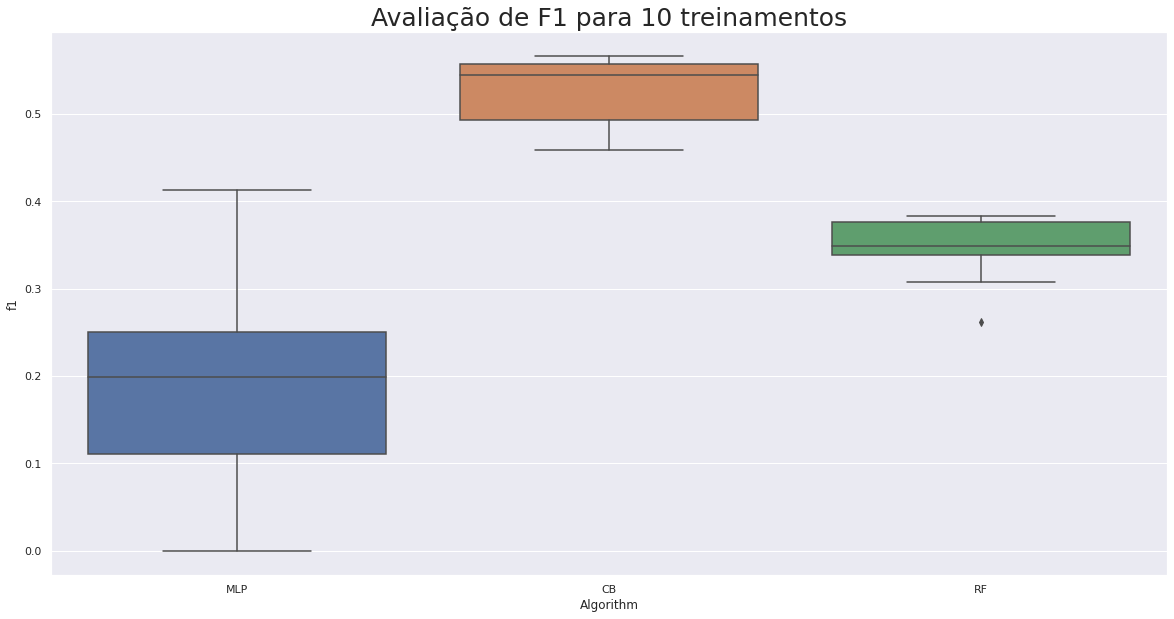

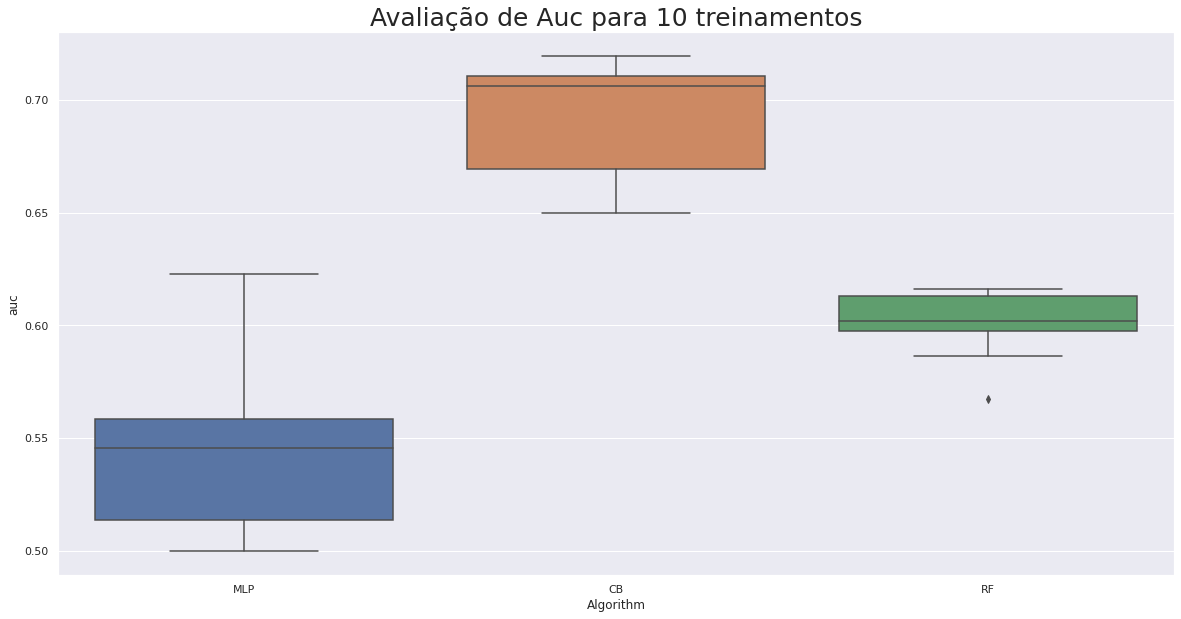

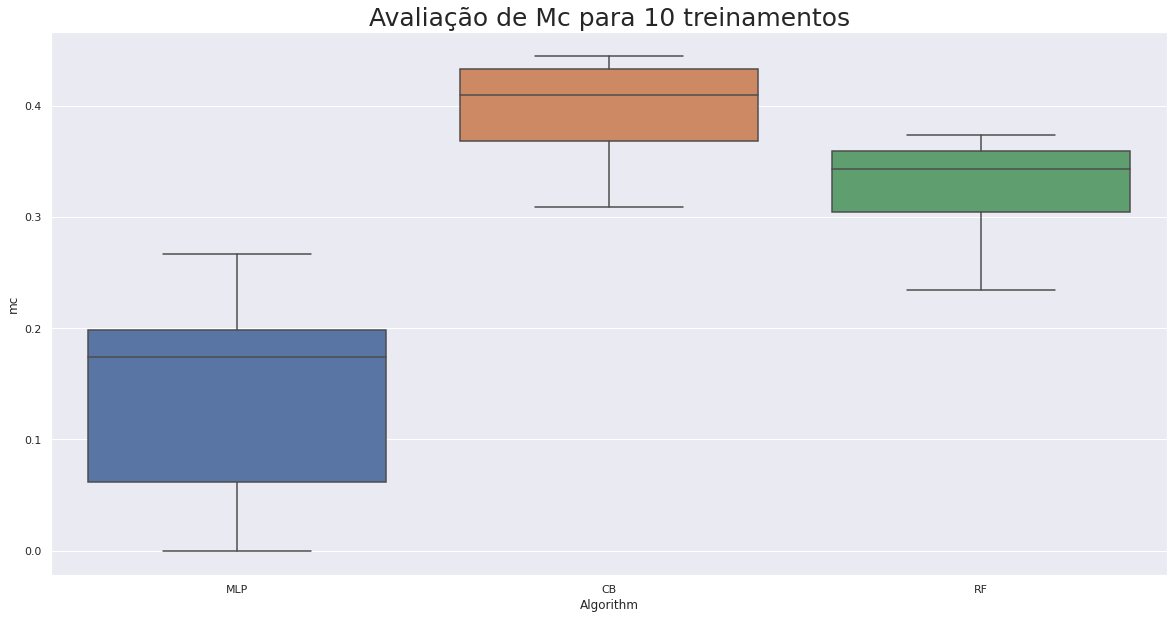

In [9]:
display_side_by_side([evaluation_summary_frame], ['Resumo das Execuções'])

for column in ['f1', 'auc', 'mc']:
    plt.figure(figsize=(20,10))
    ax = sns.boxplot(x="Algorithm", y=column, data=evaluation_frame)
    ax.set_title(f'Avaliação de {column.capitalize()} para {STRATIFIED_SPLITS} treinamentos', fontdict={'fontsize':25});